In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import execute

# create a circuit wrt tket
from qiskit.quantum_info.random import random_unitary
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector

from pytket.passes import EulerAngleReduction, KAKDecomposition

from typing import Optional, Union
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info.random import random_unitary
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library.generalized_gates.permutation import Permutation


from pytket.mapping import MappingManager
from pytket.utils import Graph
from pytket.architecture import Architecture
from pytket.circuit import Node
import networkx as nx
from pytket import Circuit, OpType
from pytket.circuit import display
from typing import List, Union, Tuple
from pytket.mapping import LexiLabellingMethod, LexiRouteRoutingMethod
from pytket.placement import Placement, LinePlacement, GraphPlacement

from pytket.passes import (
    SequencePass,
    CliffordSimp,
    DecomposeBoxes,
    KAKDecomposition,
    DefaultMappingPass,
    CXMappingPass,
    AASRouting,
    SynthesiseTket,
    RepeatPass
)

import pytket
from pytket.circuit import CustomGate
import cmath
from pytket.circuit import Circuit, CustomGateDef
from sympy import symbols

import re


In [2]:
class QuantumVolume(QuantumCircuit):
    """A quantum volume model circuit.

    The model circuits are random instances of circuits used to measure
    the Quantum Volume metric, as introduced in [1].
    """

    def __init__(
        self,
        num_qubits: int,
        depth: Optional[int] = None,
        seed: Optional[Union[int, np.random.Generator]] = None,
        classical_permutation: bool = True,
    ) -> None:
        """Create quantum volume model circuit of size num_qubits x depth
        """
        # Initialize RNG
        if seed is None:
            rng_set = np.random.default_rng()
            seed = rng_set.integers(low=1, high=1000)
        if isinstance(seed, np.random.Generator):
            rng = seed
        else:
            rng = np.random.default_rng(seed)

        # Parameters
        depth = depth or num_qubits  # how many layers of SU(4)
        width = int(np.floor(num_qubits / 2))  # how many SU(4)s fit in each layer
        name = "quantum_volume_" + str([num_qubits, depth, seed]).replace(" ", "")

        # Generator random unitary seeds in advance.
        unitary_seeds = rng.integers(low=1, high=1000, size=[depth, width])
        indices_of_gates = np.empty((depth,width,2))
        self.indices_of_gates = indices_of_gates
        # For each layer, generate a permutation of qubits
        # Then generate and apply a Haar-random SU(4) to each pair
        circuit = QuantumCircuit(num_qubits, name=name)
        self.circuit = circuit

        #circuit.initialize(create_states_new(num_qubits),circuit.qubits)
        circuit.initialize('0'*num_qubits)
        perm_0 = list(range(num_qubits))
        for d in range(depth):
            perm = rng.permutation(perm_0)
            if not classical_permutation:
                layer_perm = Permutation(num_qubits, perm)
                circuit.compose(layer_perm, inplace=True)
            for w in range(width):
                seed_u = unitary_seeds[d][w]
                su4 = random_unitary(4, seed=seed_u).to_instruction()
                su4.label = "su4_" + str(seed_u)
                if classical_permutation:
                    physical_qubits = int(perm[2 * w]), int(perm[2 * w + 1])
                    indices_of_gates[d][w] = physical_qubits
                    circuit.compose(su4, [physical_qubits[0], physical_qubits[1]], inplace=True)
                else:
                    circuit.compose(su4, [2 * w, 2 * w + 1], inplace=True)

        super().__init__(*circuit.qregs, name=circuit.name)
        self.compose(circuit.to_instruction(), qubits=self.qubits, inplace=True)

In [56]:

from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass

class ReplaceCZ(TransformationPass):
    """A transpiler pass to replace RYY and RZZ gates with RXX gates."""
    def __init__(self,angle):
        super().__init__()
        self.angle = angle

    def run(self, dag):
        """Run the pass."""

        # iterate over all operations
        for node in dag.op_nodes():

            # if we hit a RYY or RZZ gate replace it
            if node.op.name in ["cx"]:

                # calculate the replacement
                replacement = QuantumCircuit(2)

                replacement.unitary(np.array([[1, 0, 0, 0],
                                              [0, -1j*np.sin(self.angle/2.), 0, np.cos(self.angle/2.)],
                                              [0, 0, 1, 0],
                                              [0, np.cos(self.angle/2.), 0, -1j*np.sin(self.angle/2.)]]), [0, 1])
                
                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))

        return dag

In [11]:
def find_indices(sv, sv1):
    indices = []
    for i in range(len(sv)):
        for j in range(len(sv1)):
            if abs(sv[i]-sv1[j]) < 0.0001:
                indices.append(j)
    return indices

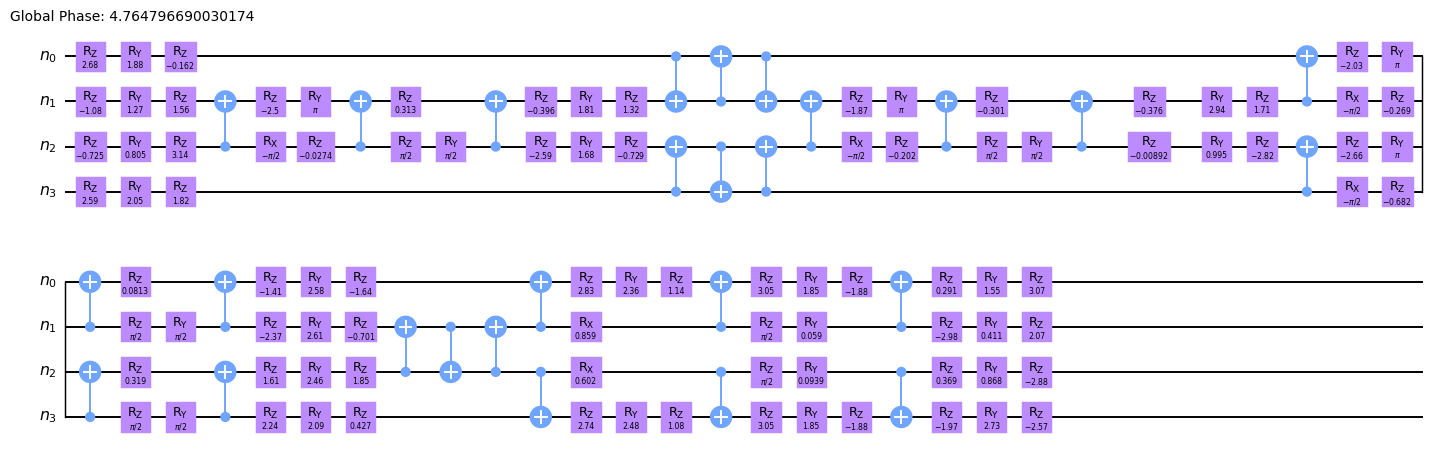

In [136]:
n_qubits = 4

QV = QuantumVolume(n_qubits, classical_permutation = False)
initial_circuit = QV.circuit

basis_gates = ['rx', 'ry', 'rz', 'cx']
n = [Node("n", i) for i in range(n_qubits)]
id_coupling_map = []
for j in range(n_qubits-1): id_coupling_map.append([n[j],n[j+1]])
id_architecture = Architecture(id_coupling_map)

classical_circuit = transpile(initial_circuit, basis_gates=basis_gates)

static_circuit = qiskit_to_tk(classical_circuit)
dynamic_circuit = static_circuit.copy()

DecomposeBoxes().apply(static_circuit)
optimise = SequencePass([KAKDecomposition(),  CXMappingPass(id_architecture, Placement(id_architecture)), CliffordSimp(False), SynthesiseTket()])
optimise.apply(static_circuit)
optimise.apply(static_circuit)
optimise.apply(static_circuit)

DecomposeBoxes().apply(dynamic_circuit)
optimise = SequencePass([KAKDecomposition(),  CliffordSimp(False), SynthesiseTket()])
optimise.apply(dynamic_circuit)
optimise.apply(dynamic_circuit)
optimise.apply(dynamic_circuit)

static_circ_qiskit = tk_to_qiskit(static_circuit)
dynamic_circ_qiskit = tk_to_qiskit(dynamic_circuit)

static_circ_qiskit = transpile(static_circ_qiskit, basis_gates=basis_gates)
dynamic_circ_qiskit = transpile(dynamic_circ_qiskit, basis_gates=basis_gates)

static_circ_qiskit.draw(output='mpl', scale = 0.7, fold = 30)


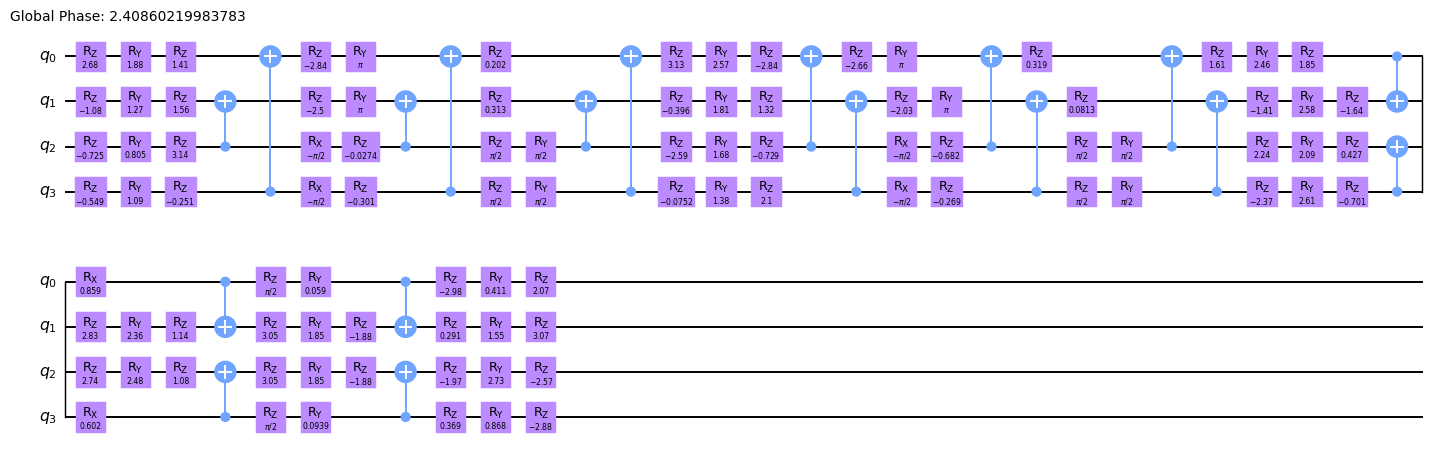

In [137]:
dynamic_circ_qiskit.draw(output='mpl', scale = 0.7, fold = 30)

In [150]:
error = 0.005
delta  = 2*np.arccos(np.sqrt(4 - 5*error) - 1)
# (3 - np.cos(delt/2)**2 - 2*np.cos(delt/2))/5
err_static_circ = ReplaceCZ(delta)(static_circ_qiskit)
err_dynamic_circ = ReplaceCZ(delta)(dynamic_circ_qiskit)

In [151]:
classical_amps = Statevector.from_instruction(classical_circuit)
static_amps = Statevector.from_instruction(err_static_circ)
dynamic_amps = Statevector.from_instruction(err_dynamic_circ)

indices_static = find_indices(classical_amps, Statevector.from_instruction(static_circ_qiskit))
indices_dynamic = find_indices(classical_amps, Statevector.from_instruction(dynamic_circ_qiskit))

#print(classical_amps,  Statevector.from_instruction(static_circ_qiskit),  Statevector.from_instruction(static_circ_qiskit))

classical_amps = np.array(classical_amps)
static_amps = np.array(static_amps)[indices_static]
dynamic_amps = np.array(dynamic_amps)[indices_dynamic]

print(np.sort(np.abs(classical_amps)**2), '\n' , np.sort(np.abs(static_amps)**2), '\n', np.sort(np.abs(dynamic_amps)**2))

[0.0053505  0.00896179 0.01024762 0.01076006 0.01574602 0.02863865
 0.03369335 0.04254812 0.04484973 0.06983053 0.07286432 0.07828135
 0.08091295 0.08781968 0.09907784 0.31041752] 
 [0.00317403 0.00832639 0.01098477 0.0180835  0.02447413 0.02889805
 0.04843189 0.05019504 0.06056572 0.06585089 0.06989114 0.0859066
 0.08910545 0.09501833 0.10201074 0.23908333] 
 [0.00242765 0.00867499 0.01290893 0.01788599 0.02253396 0.04040968
 0.0484059  0.05293034 0.0584378  0.06452308 0.0685688  0.0770455
 0.07734073 0.07826623 0.10279338 0.26684703]


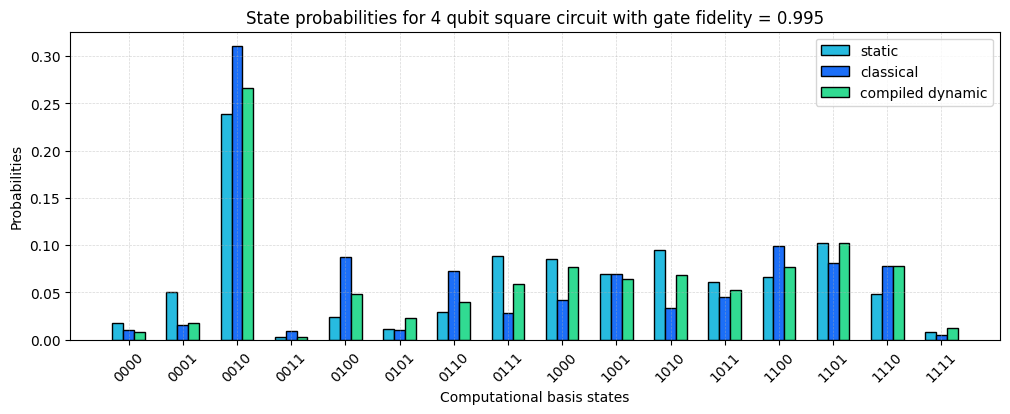

In [154]:
plot_states = [0]*2**n_qubits
for i in range(2**n_qubits):
    plot_states[i] = "{0:b}".format(i).zfill(n_qubits)


plot_states = np.array(plot_states) 
X_axis = np.arange(len(plot_states))

plt.figure(figsize=(12,4))

plt.bar(X_axis - 0.2, np.abs(static_amps)**2, 0.2, label = 'static', color = '#27bbe0', edgecolor = 'black')
plt.bar(X_axis, np.abs(classical_amps)**2, 0.2, label = 'classical', color = '#1c6ff8', edgecolor = 'black')
plt.bar(X_axis + 0.2, np.abs(dynamic_amps)**2, 0.2, label = 'compiled dynamic', color = '#31db92', edgecolor = 'black')
#plt.bar(X_axis + 0.3, plot_amps_dc**2, 0.2, label = 'compiled dynamic')


# plt.plot(X_axis, plot_amps_i, label = 'classical')
# plt.plot(X_axis, plot_amps_d, label = 'dynamic without atom loss')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.xticks(X_axis, plot_states, rotation = 45)
plt.xlabel("Computational basis states")
plt.ylabel("Probabilities")
plt.title(f"State probabilities for {n_qubits} qubit square circuit with gate fidelity = {1 - error}")
plt.legend()
plt.show()

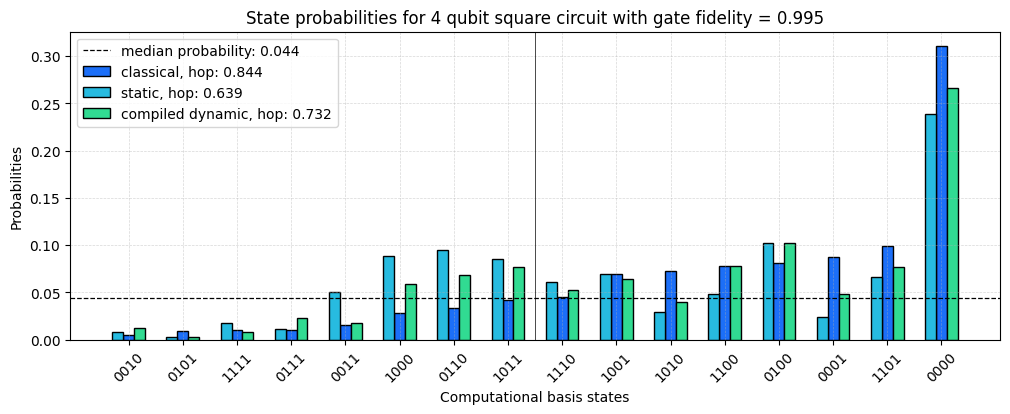

0.8440539043984403 0.6392058857129055 0.7315163814380576


In [156]:
probs_ascending_order_c = np.argsort(np.abs(classical_amps)**2)
sorted_probs_c = (np.abs(classical_amps)**2)[probs_ascending_order_c]
sorted_probs_s = (np.abs(static_amps)**2)[probs_ascending_order_c]
sorted_probs_du = (np.abs(dynamic_amps)**2)[probs_ascending_order_c]

# sorted_probs_i = np.sort(plot_amps_i**2)
# sorted_probs_d = np.sort(plot_amps_d**2)
plot_states = np.array(plot_states)[probs_ascending_order_c]

plt.figure(figsize=(12,4))

plt.bar(X_axis, sorted_probs_c, 0.2, label = f'classical, hop: {round(np.sum(sorted_probs_c[sorted_probs_c>np.median(sorted_probs_c)]),3)} ', color = '#1c6ff8', edgecolor = 'black')
plt.bar(X_axis - 0.2, sorted_probs_s, 0.2, label = f'static, hop: {round(np.sum(sorted_probs_s[sorted_probs_c>np.median(sorted_probs_c)]),3)}', color = '#27bbe0', edgecolor = 'black')
plt.bar(X_axis + 0.2, sorted_probs_du, 0.2, label = f'compiled dynamic, hop: {round(np.sum(sorted_probs_du[sorted_probs_c>np.median(sorted_probs_c)]),3)}', color = '#31db92', edgecolor = 'black')
#plt.bar(X_axis + 0.3, sorted_probs_dc, 0.2, label = 'compiled dynamic')

plt.axhline(y = np.median(sorted_probs_c), color = 'black', linestyle = '--', label = f"median probability: {round(np.median(sorted_probs_c),3)}", linewidth = 0.9)
#plt.axhline(y = np.median(sorted_probs_du), color = 'orange', linestyle = '--', label = f"median of dynamic: {round(np.median(sorted_probs_du),3)}")
#plt.axhline(y = np.median(sorted_probs_s), color = 'green', linestyle = '--', label = f"median of static: {round(np.median(sorted_probs_s),3)}")
plt.axvline(x = np.median(X_axis), color = 'black', linestyle = '-', linewidth = 0.5)

# plt.plot(X_axis, plot_amps_i, label = 'classical')
# plt.plot(X_axis, plot_amps_d, label = 'dynamic without atom loss')

plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.xticks(X_axis, plot_states, rotation = 45)
plt.xlabel("Computational basis states")
plt.ylabel("Probabilities")
plt.title(f"State probabilities for {n_qubits} qubit square circuit with gate fidelity = {1 - error}")
plt.legend()
plt.show()
print(np.sum(sorted_probs_c[sorted_probs_c>np.median(sorted_probs_c)]), np.sum(sorted_probs_s[sorted_probs_c>np.median(sorted_probs_c)]), np.sum(sorted_probs_du[sorted_probs_c>np.median(sorted_probs_c)]))